# Testing bounding box conversion & IOU

* Code taken from [Oriented RepPoints](https://github.com/LiWentomng/OrientedRepPoints/tree/main/mmdet/ops).

In [201]:
%reload_ext autoreload
%autoreload 2

import torch
import random
import matplotlib.pyplot as plt
from matplotlib import patches
from math import pi
from obb.utils.box_ops import *

In [202]:
def gen_random_clusters(B=10, N=9, im_dim=(256, 256), cluster_dim=(40, 40)):
    """ Generates a [B, N, 2] tensor with B clusters, N points each."""

    x_im, y_im = im_dim
    x_cluster, y_cluster = cluster_dim

    # Generate random centers
    x0_lst = torch.randint(0, x_im, (B,))
    y0_lst = torch.randint(0, y_im, (B,))

    # Generate random angles uniformly-distributed in the interval [-0.5*pi,0.5*pi)
    theta_lst = torch.rand((B,)) * pi - 0.5 * pi
    c_lst = torch.cos(theta_lst)
    s_lst = torch.sin(theta_lst)

    # Generate random cluster dimensions
    x_scale_lst = torch.randint(5, x_cluster, (B,))
    y_scale_lst = torch.randint(5, y_cluster, (B,))

    # Generate the random points for each cluster
    point_lst = []

    for x0, y0, c, s, x_scale, y_scale in zip(x0_lst, y0_lst, c_lst, s_lst, x_scale_lst, y_scale_lst):
        # Generate random offsets
        dx = torch.randint(0, x_scale, (N,))
        dy = torch.randint(0, y_scale, (N,))

        # Apply rotation
        dx_rot = c * dx - s * dy
        dy_rot = s * dx + c * dy

        points = torch.stack([x0 + dx_rot, y0 + dy_rot], dim=1) # [N, 2]
        point_lst.append(points)

    return torch.stack(point_lst) # [B, N, 2]

Cluster tensor shape: torch.Size([40, 9, 2])
Convex hull tensor shape: torch.Size([40, 9, 2])


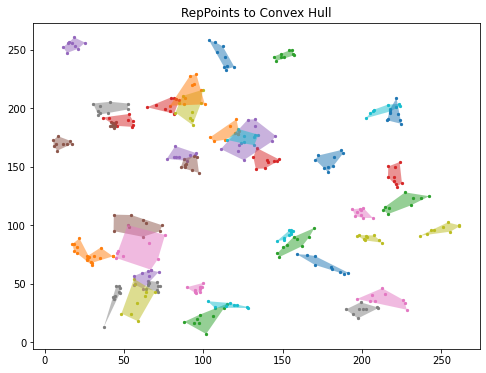

In [209]:
clusters = gen_random_clusters(B=40)
print(f'Cluster tensor shape: {clusters.shape}')

hull = convex_hull(clusters)
print(f'Convex hull tensor shape: {hull.shape}')

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1, 1, 1)
for cluster in clusters:
    sc = ax.scatter(cluster[:, 0], cluster[:, 1], s=5)

for cluster in hull:
    # poly = patches.Polygon(cluster, closed=True, fill=False)
    # ax.add_patch(poly)
    ax.fill(cluster[:, 0], cluster[:, 1], alpha=0.5)

plt.title('RepPoints to Convex Hull')
plt.show()